In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
from sqlalchemy import inspect
inspector = inspect(engine)

In [11]:
columns = inspector.get_columns("station")
for c in columns:
    print(c["name"])

id
station
name
latitude
longitude
elevation


In [12]:
name_list = session.query(Station.name).all()
name_list

[('WAIKIKI 717.2, HI US'),
 ('KANEOHE 838.1, HI US'),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('PEARL CITY, HI US'),
 ('UPPER WAHIAWA 874.3, HI US'),
 ('WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('WAIHEE 837.5, HI US'),
 ('HONOLULU OBSERVATORY 702.2, HI US'),
 ('MANOA LYON ARBO 785.2, HI US')]

In [13]:
# Save the station data for later use in the API
station_list_to_use = session.query(Station.station, Station.name).all()
station_list_to_use

[('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00513117', 'KANEOHE 838.1, HI US'),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00517948', 'PEARL CITY, HI US'),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00519281', 'WAIHEE 837.5, HI US'),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US')]

In [14]:
station_dict = dict(station_list_to_use)
station_dict

{'USC00519397': 'WAIKIKI 717.2, HI US',
 'USC00513117': 'KANEOHE 838.1, HI US',
 'USC00514830': 'KUALOA RANCH HEADQUARTERS 886.9, HI US',
 'USC00517948': 'PEARL CITY, HI US',
 'USC00518838': 'UPPER WAHIAWA 874.3, HI US',
 'USC00519523': 'WAIMANALO EXPERIMENTAL FARM, HI US',
 'USC00519281': 'WAIHEE 837.5, HI US',
 'USC00511918': 'HONOLULU OBSERVATORY 702.2, HI US',
 'USC00516128': 'MANOA LYON ARBO 785.2, HI US'}

In [15]:
import json

with open('Resources/stations.json', 'w') as f:
    json.dump(station_dict, f)

In [16]:
# Find the station with the most amount of data
sorted_results_list = session.query(Measurement.station, func.count(Measurement.station))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc()).all()
sorted_results_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
my_station = sorted_results_list[0][0]
my_station

'USC00519281'

In [18]:
columns = inspector.get_columns("measurement")
for c in columns:
    print(c["name"])

id
station
date
prcp
tobs


In [19]:
# Check the end date of the data
end_date = session.query(Measurement.date).\
                   filter(Measurement.station == my_station).\
                   order_by(Measurement.date.desc()).first()[0]
end_date

'2017-08-18'

In [20]:
end_date = dt.datetime.strptime(end_date, '%Y-%m-%d')
end_date

datetime.datetime(2017, 8, 18, 0, 0)

In [21]:
begin_date = end_date - dt.timedelta(days=365)
begin_date

datetime.datetime(2016, 8, 18, 0, 0)

In [22]:
# Perform a query to retrieve the data and precipitation scores
from sqlalchemy import and_

data_last_year = session.query(Measurement)\
                 .filter(and_(Measurement.station == my_station,
                              Measurement.date >= begin_date,
                              Measurement.date <= end_date,))

In [23]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df_last_year = pd.read_sql(data_last_year.statement, session.bind, index_col="date")

In [24]:
df_last_year.head()

,id,station,prcp,tobs
date,,,,
2016-08-19,14604,USC00519281,0.31,79.0
2016-08-20,14605,USC00519281,0.13,81.0
2016-08-21,14606,USC00519281,0.08,79.0
2016-08-22,14607,USC00519281,2.32,78.0
2016-08-23,14608,USC00519281,1.79,77.0


In [25]:
df_last_year.tail()

,id,station,prcp,tobs
date,,,,
2017-08-14,14955,USC00519281,0.00,77.0
2017-08-15,14956,USC00519281,0.32,77.0
2017-08-16,14957,USC00519281,0.12,76.0
2017-08-17,14958,USC00519281,0.01,76.0
2017-08-18,14959,USC00519281,0.06,79.0


In [26]:
len(df_last_year)

356

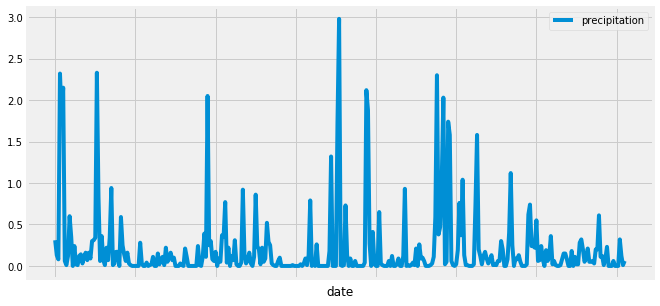

In [27]:
import os

series_last_year = df_last_year["prcp"]
series_last_year.plot(figsize=(10, 5))

plt.xlabel("date")
plt.legend(labels=["precipitation"], loc="upper right")

plt.savefig(os.getcwd() + "/My_Images/prcp.png", bbox_inches='tight')

In [28]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_last_year["prcp"].describe().to_frame(name="precipitation")

,precipitation
count,356.000000
mean,0.204691
std,0.431811
min,0.000000
25%,0.000000
50%,0.060000
75%,0.192500
max,2.980000


In [29]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [30]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sorted_results_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [31]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
            .filter(Measurement.station == sorted_results_list[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

In [32]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tops_data = session.query(Measurement.tobs)\
                .filter(and_(Measurement.station == my_station,
                              Measurement.date >= begin_date,
                              Measurement.date <= end_date,)).all()

In [33]:
tops_data = [data[0] for data in tops_data]

In [34]:
len(tops_data)

356

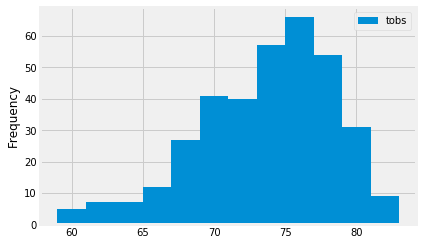

In [35]:
plt.hist(tops_data, bins=12)

plt.ylabel("Frequency")
plt.legend(labels=["tobs"], loc="upper right")

plt.savefig(os.getcwd() + "/My_Images/tobs.png", bbox_inches='tight')
plt.show()

In [36]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [37]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_start_date = "2018-05-17"
trip_end_date = "2018-05-27"

# Calculate the start and end date for previous year
start_date = trip_start_date.replace("2018", "2017")
end_date = trip_end_date.replace("2018", "2017")
print(start_date)
print(end_date)

2017-05-17
2017-05-27


In [38]:
result = calc_temps(start_date, end_date)
result

[(68.0, 74.59677419354838, 87.0)]

In [39]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
T_min = result[0][0]
T_avg = result[0][1]
T_max = result[0][2]

print(T_min, T_avg, T_max)

68.0 74.59677419354838 87.0


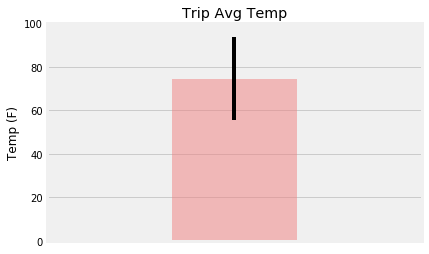

In [40]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar(0, T_avg, yerr=(T_max - T_min), width=0.2, color='lightcoral', alpha=0.5)
plt.xlim(-0.3, 0.3)
plt.ylim(0, 100)
plt.xticks([], [])
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")

plt.savefig(os.getcwd() + "/My_Images/trip_avg_temp.png", bbox_inches='tight')
plt.show()

In [41]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Create a subquery
sel = [
    Measurement.station, 
    Measurement.prcp, 
    Station.name,
    Station.latitude, 
    Station.longitude, 
    Station.elevation,
]

q = session.query(*sel)\
        .outerjoin(Station, Measurement.station == Station.station)\
        .filter(Measurement.date >= start_date)\
        .filter(Measurement.date <= end_date)\
        .subquery()

In [42]:
sel = [
    q.c.station, 
    q.c.name, 
    q.c.latitude, 
    q.c.longitude, 
    q.c.elevation, 
    func.sum(q.c.prcp),
]

print(session.query(*sel)\
                .group_by(q.c.station).order_by(func.sum(q.c.prcp).desc()).all())

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 4.35), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 1.62), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.12), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.8600000000000001), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.46), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.38)]


## Optional Challenge Assignment

In [43]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [44]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start_date = dt.datetime.strptime(trip_start_date, '%Y-%m-%d')
trip_end_date = dt.datetime.strptime(trip_end_date, '%Y-%m-%d')
print(trip_start_date)
print(trip_end_date)

2018-05-17 00:00:00
2018-05-27 00:00:00


In [45]:
# Use the start and end date to create a range of dates
range_of_dates = []
date = trip_start_date
while date <= trip_end_date:
    range_of_dates.append(date)
    date += dt.timedelta(days=1)

In [46]:
range_of_dates

[datetime.datetime(2018, 5, 17, 0, 0),
 datetime.datetime(2018, 5, 18, 0, 0),
 datetime.datetime(2018, 5, 19, 0, 0),
 datetime.datetime(2018, 5, 20, 0, 0),
 datetime.datetime(2018, 5, 21, 0, 0),
 datetime.datetime(2018, 5, 22, 0, 0),
 datetime.datetime(2018, 5, 23, 0, 0),
 datetime.datetime(2018, 5, 24, 0, 0),
 datetime.datetime(2018, 5, 25, 0, 0),
 datetime.datetime(2018, 5, 26, 0, 0),
 datetime.datetime(2018, 5, 27, 0, 0)]

In [47]:
# Stip off the year and save a list of %m-%d strings
range_of_dates_str = [item.strftime("%m-%d") for item in range_of_dates]

In [48]:
range_of_dates_str

['05-17',
 '05-18',
 '05-19',
 '05-20',
 '05-21',
 '05-22',
 '05-23',
 '05-24',
 '05-25',
 '05-26',
 '05-27']

In [49]:
# Loop through the list of %m-%d strings and calculate the normals for each date
data = [daily_normals(date)[0] for date in range_of_dates_str]

In [50]:
data

[(68.0, 74.45, 79.0),
 (68.0, 74.10714285714286, 82.0),
 (65.0, 73.80701754385964, 79.0),
 (68.0, 73.89655172413794, 79.0),
 (64.0, 72.96428571428571, 80.0),
 (64.0, 74.45614035087719, 80.0),
 (68.0, 74.94827586206897, 87.0),
 (67.0, 73.94827586206897, 79.0),
 (68.0, 74.27586206896552, 79.0),
 (65.0, 74.03636363636363, 82.0),
 (65.0, 74.49090909090908, 80.0)]

In [51]:
df = pd.DataFrame(data, columns=["tmin", "tavg", "tmax"])
df["date"] = [item.strftime("%Y-%m-%d") for item in range_of_dates]
df = df.set_index("date")

In [55]:
df

,tmin,tavg,tmax
date,,,
2018-05-17,68.0,74.450000,79.0
2018-05-18,68.0,74.107143,82.0
2018-05-19,65.0,73.807018,79.0
2018-05-20,68.0,73.896552,79.0
2018-05-21,64.0,72.964286,80.0
2018-05-22,64.0,74.456140,80.0
2018-05-23,68.0,74.948276,87.0
2018-05-24,67.0,73.948276,79.0
2018-05-25,68.0,74.275862,79.0


In [61]:
df.index

Index(['2018-05-17', '2018-05-18', '2018-05-19', '2018-05-20', '2018-05-21',
       '2018-05-22', '2018-05-23', '2018-05-24', '2018-05-25', '2018-05-26',
       '2018-05-27'],
      dtype='object', name='date')

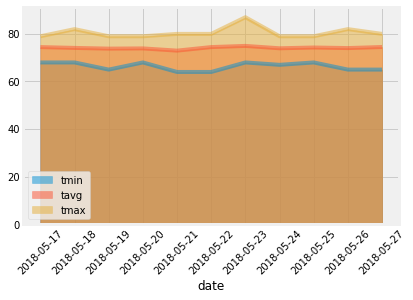

In [70]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, alpha=0.5, rot=45)
plt.xticks(list(range(len(df.index))), df.index)

plt.savefig(os.getcwd() + "/My_Images/daily_avg.png", bbox_inches='tight')
plt.show()